In [41]:
# Imports
%pylab inline
import pickle
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Path to file
filename = '/Users/alexbw/Downloads/fingerprints.pkl'

In [6]:
# Load the fingerprints
with open(filename, 'rb') as f:
    fingerprints, fingerprint_labels = pickle.load(f, encoding='latin1')

In [46]:
drug = fingerprint_labels['drug']
dose = fingerprint_labels['dose']
drug_class = fingerprint_labels['drug_class']

drugs = [
    "alprazolam",
    "diazepam",
    "bupropion",
    "phenelzine",
    "chlorpromazine",
    "clozapine",
    "haloperidol",
    "risperidone",
    "atomoxetine",
    "venlafaxine",
    "citalopram",
    "fluoxetine",
    "methamphetamine",
    "methylphenidate",
    "modafinil",
    "saline",
    "controls",
    "control"
]

highlow_dose_mapping = fingerprint_labels['highlow_dose_mapping']

highorlow = []
for dr,do in zip(drug,dose):
    if do in highlow_dose_mapping[dr]:
        highorlow.append(highlow_dose_mapping[dr][do])
    else:
        highorlow.append("None")
highorlow = np.array(highorlow)

In [47]:
moseq = fingerprints['moseq'].astype('float32')
speed = fingerprints['speed'].astype('float32')
simplepose = fingerprints['simplepose'].astype('float32')
position = fingerprints['position'].astype('float32')
scalars = fingerprints['scalars'].astype('float32')

dose_label_map = dict(zip(['Extremely Low','Very Low', 'Low', 'Medium', 'High', 'Very High'],range(6)))
y_highorlow = np.array([dose_label_map[i] for i in highorlow])

y_drug = LabelEncoder().fit_transform(drug)
y_class = LabelEncoder().fit_transform(drug_class)
y_dose = LabelEncoder().fit_transform(["%s %s"%z for z in zip(drug,dose)])
yt_drug = np.r_[0,np.argwhere(np.diff(y_drug)).ravel()] + 10
yt_class = np.r_[0,np.argwhere(np.diff(y_class)).ravel(),len(y_class)]
yt_class = ((yt_class[:-1]+yt_class[1:])/2.0).astype('int32')

In [48]:
ticks = {
"Length & Height": np.hstack(((np.linspace(20,100,45)),np.linspace(0,60,45))),
"Speed": np.linspace(0,400,90),
"Position": np.linspace(0,1,90),
"MoSeq": np.arange(0,160),
}

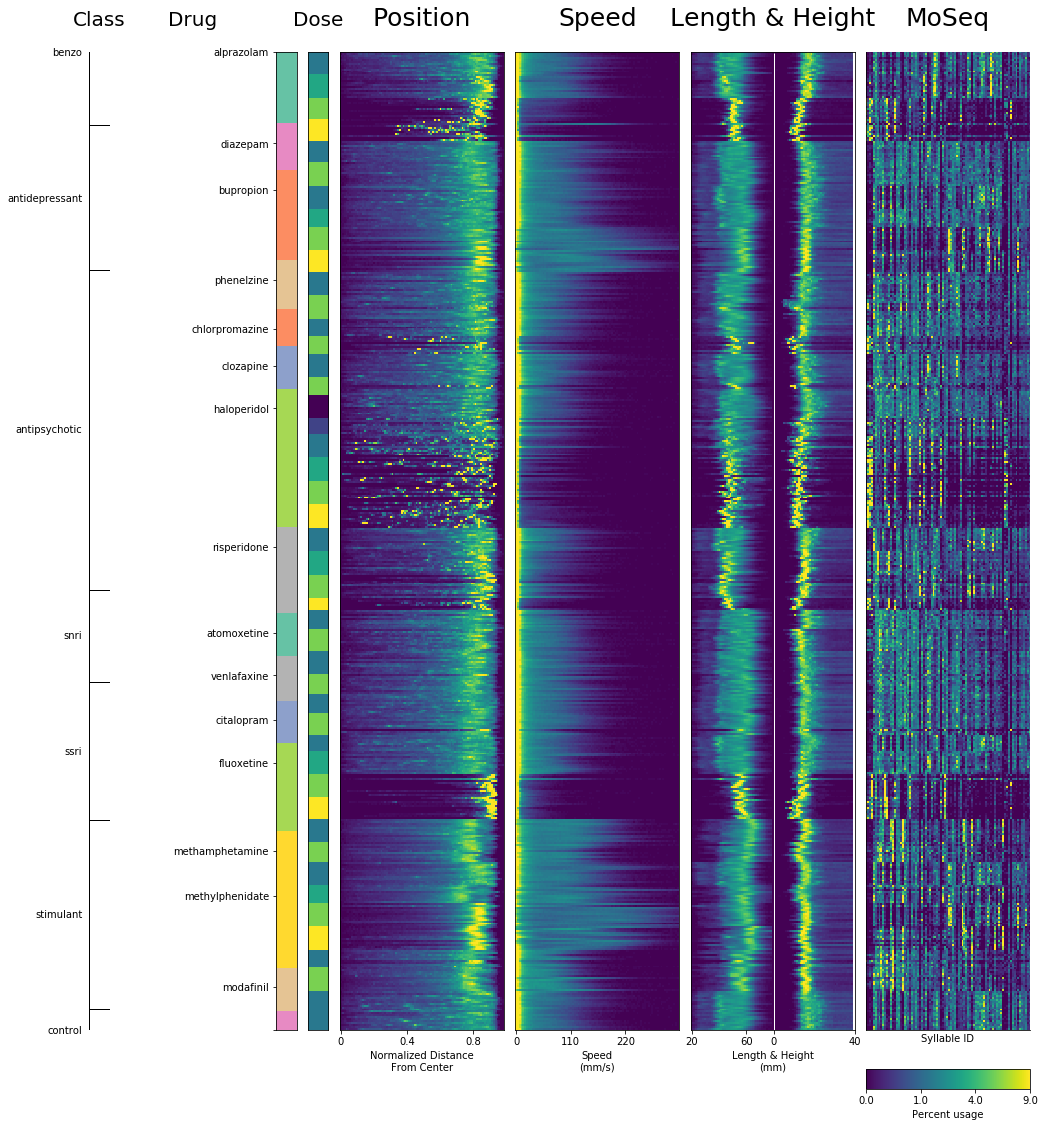

In [49]:
header_fontsize=25
axis_scale=0.8

figure(figsize=(20,18))


gs = GridSpec(1, 9, wspace=0.1, width_ratios=[1,7,1,1,8,8,8,8,8])

subplot(gs[0])
tick_locs = np.r_[0,np.argwhere(np.diff(y_class)!=0).ravel(),len(y_class)]
for t in tick_locs:
    hlines(t,0,1,color='k',linewidth=1)
vlines(0,0,tick_locs[-1],linewidth=1)
ylim(-1,len(y_class)+1)
gca().invert_yaxis()
xlim(0,1)
yticks(yt_class, np.array(drug_class)[yt_class], )
xticks([])
gca().spines['top'].set_visible(False)
gca().spines['right'].set_visible(False)
gca().spines['bottom'].set_visible(False)
gca().spines['left'].set_visible(False)
gca().yaxis.set_ticks_position('none') 

title('Class',fontsize=header_fontsize*axis_scale, y=1.02)

subplot(gs[1])
title('Drug',fontsize=header_fontsize*axis_scale, y=1.02)
axis('off')

subplot(gs[2])
imshow(y_drug[:,None], interpolation='none', cmap='Set2')
axis('tight')
yticks(yt_drug, drugs[:-1])
xticks([])

subplot(gs[3])
imshow(y_highorlow[:,None], interpolation='none', cmap='viridis')
axis('tight')
xticks([]); yticks([]);
title('Dose',fontsize=header_fontsize*axis_scale, y=1.02)

for i,(key,data,scalefn,clim,units) in enumerate([
                         ("Position", position, np.sqrt,(0,0.3),"Normalized Distance\nFrom Center"),
                         ("Speed", speed,np.sqrt, (0,0.3), "Speed\n(mm/s)"),
                         ("Length & Height", simplepose, np.sqrt, (0,0.3), "Length & Height\n(mm)"),
                         ("MoSeq", moseq, np.sqrt, (0,0.3), "Syllable ID"),
                        ]):
    
    # Normalize
    data = (data.T/data.sum(1)).T

    subplot(gs[i+4])
    ax1 = imshow(scalefn(data), clim=clim, interpolation='nearest')
    _xticks = np.floor(ticks[key][::25]/10.0)*10.0
    if key == 'Position':
        ax1.axes.set_xticks([0,36, 72])
        ax1.axes.set_xticklabels([0,0.4,0.8])
    else:
        ax1.axes.set_xticks(np.linspace(0,data.shape[1],len(_xticks)))
        ax1.axes.set_xticklabels(map(int,_xticks))
    yticks([])
    axis('tight')
    xlabel(units)
    title(key,y=1.02,fontsize=header_fontsize)
    if key == 'Length & Height':
        vlines(45,0,len(data),linewidth=1,color='w')
        xticks([0,30,45,89])
    elif key == "MoSeq":
        xlim(0,85)
        xticks([])

cbaxes = add_subplot_axes(gca(), [0,-0.06,1.0,0.02])
cb = plt.colorbar(ax1, cax = cbaxes, orientation='horizontal')
cticks = np.linspace(clim[0],clim[1],4)
cb.set_ticks(cticks)
cb.set_ticklabels(np.around(100*cticks**2.0), 2
cb.set_label("Percent usage")
sns.despine(ax=ax1.axes)